  # CLASSIFICAÇÃO DE ESTRELAS COM DADOS DO GAIA.

# Introdução

Este notebook tem como finalidade a classificação de estrelas usando dados do telescópio espacial GAIA, utilizando técnicas de aprendizado não supervisionado. Os dados principais foram obtidos do próprio banco de dados SQL do telescópio (https://gea.esac.esa.int/archive/), enquanto os adicionais, de distância, foram buscados também em linguagem SQL, mas dessa vez usando python.
  
O projeto consiste em:

-> 1-Importação e Instalação das bibliotecas;

-> 2-Aquisição dos Dados;

-> 3-Tratamento dos Dados;

-> 4-Análise Exploratória;

-> 5-Preparação dos Modelos;

-> 6-Aplicação dos Modelos;

-> 7-Ajuste dos modelos;

-> 8-Resultados;

-> 9-Conclusão. 

------------------------------------------------------------------------------------------------------------------------------

# 1 - IMPORTANDO E INSTALANDO AS BIBLIOTECAS.

## 1.1 - Instalação de Novas Bibliotecas.

In [43]:
# Instalando o pacote yellowbrick para visualização de hiperparâmetros.

pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [12]:
## Instalando astroquery para a busca de dados em base de dados astronômicas.

pip install --pre astroquery

  Using cached astroquery-0.4.5.dev7147-py3-none-any.whl (4.5 MB)
  Using cached pyvo-1.1-py3-none-any.whl (802 kB)
  Using cached mimeparse-0.1.3-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


## 1.2 - Importando as Bibliotecas.

In [22]:
# Principais bibliotecas.
import pandas as pd
import numpy as np
from astropy.table import Table, Column

#Bibliotecas de Visualização.
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gridspec
from yellowbrick.cluster import silhouette_visualizer, KElbowVisualizer

#Bibliotecas de busca.
from astroquery.gaia import Gaia

#Bibliotecas de Machine Learning.
from scipy.stats import normaltest
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, OPTICS, cluster_optics_dbscan
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: numpy.core.multiarray failed to import

In [7]:
pip uninstall numpy
pip install numpy==1.19.3

SyntaxError: invalid syntax (Temp/ipykernel_8220/3834769887.py, line 1)

-------------------------------------------------------------------------------------------------------------------------------

# 2 - AQUISIÇÃO DOS DADOS.

## 2.1 - Telescópio GAIA.

A aquisição dos dados principais do GAIA foi feita através de uma busca no banco de dados SQL do próprio telescópio espacial (https://gea.esac.esa.int/archive/), buscando os melhores resultados limitando a uma parallax de 5x10^(-3) segundos de arco, que equilave a uma distância máxima de 652 anos luz. 

                                                              👇
<img src='busca_sql.png'>


*Tentar aprimorar a busca nas outras tabelas usando os ids da primeira busca!

## 2.2 - Dados complementares (Distância).

A base de dados do GAIA contém dados de diversos telescópios que podem ser acessados via astroquery (módulo do pacote astropy) e, coletados através de uma busca em SQL.  

In [2]:
# Mostrando as tabelas existentes na base de dados do GAIA.

tables = Gaia.load_tables(only_names=True)
for table in tables:
    print(table.name)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
external.apassdr9
external.gaiadr2_geometric_distance
external.gaiaedr3_distance
external.galex_ais
external.ravedr5_com
external.ravedr5_dr5
external.ravedr5_gra
external.ravedr5_on
external.sdssdr13_photoprimary
external.skymapperdr1_master
external.skymapperdr2_master
external.tmass_xsc
gaiadr1.aux_qso_icrf2_match
gaiadr1.ext_phot_zero_point
gaiadr1.allwise_best_neighbour
gaiadr1.allwise_neighbourhood
gaiadr1.gsc23_best_neighbour
gaiadr1.gsc23_neighbourhood
gaiadr1.ppmxl_best_neighbour
gaiadr1.ppmxl_neighbourhood
gaiadr1.sdss_dr9_best_neighbour
gaiadr1.sdss_dr9_neighbourhood
gaiadr1.tmass_best_neighbour
gaiadr1.tmass_neighbourhood
gaiadr1.ucac4_best_neighbour
gaiadr1.ucac4_neighbourhood
gaiadr1.urat1_best_neighbour
gaiadr1.urat1_neighbourhood
gaiadr1.cepheid
gaiadr1.phot_variable_time_series_gfov
gaiadr1.phot_variable_time_series_gfov_sta

No nosso caso, estamos interessados nas informações sobre as distâncias das estrelas que são encontradas na tabela 'external.gaiaedr3_distance'.

In [3]:
# Acessando a tabela com as informações sobre a distância.

table_metadata = Gaia.load_table('external.gaiaedr3_distance')
print(table_metadata)

Retrieving table 'external.gaiaedr3_distance'
TAP Table name: external.external.gaiaedr3_distance
Description: 
Bailer-Jones et al. (2021) EDR3 distances. <p> Estimating distances from parallaxes. V: Geometric and photogeometric distances to 1.47 billion stars in Gaia Early Data Release 3.
Bailer-Jones et al. 2021 AJ 161 147. Data replicated from gedr3dist.main table at GAVO Data Center TAP service https://dc.g-vo.org/tap and TAP metadata as of December 2020.
<p>
    Original table description.
<p>
    We estimate the distance from the Sun to sources in Gaia EDR3 that have
    parallaxes. We provide two types of distance estimate, together with
    their corresponding asymmetric uncertainties, using Bayesian posterior
    density functions that we sample for each source. Our prior is based
    on a detailed model of the 3D spatial, colour, and magnitude
    distribution of stars in our Galaxy that includes a 3D map of
    interstellar extinction.
<p>
    The first type of distance esti

In [4]:
# Verificando as colunas nas tabela 'external.gaiaedr3_distance'.

for column in table_metadata.columns:
    print(column.name)

source_id
r_med_geo
r_lo_geo
r_hi_geo
r_med_photogeo
r_lo_photogeo
r_hi_photogeo
flag


Vemos que a tabela possui várias colunas, mas estamos interessados apenas na distância geométrica (r_med_geo), que será buscado através da query seguinte, junto com o ID para fundirmos com a outra base de dados.

In [6]:
query = """SELECT TOP 10000
source_id, r_med_geo 
FROM external.gaiaedr3_distance
WHERE (external.gaiaedr3_distance.r_med_geo<200)"""


In [7]:
# Busca dos dados.

job = Gaia.launch_job(query)
job

In [8]:
print(job)

<Table length=10000>
   name    dtype  unit                                           description                                          
--------- ------- ---- -----------------------------------------------------------------------------------------------
source_id   int64      Unique source identifier. Note that this *cannot* be matched against the DR1 or DR2 source_ids.
r_med_geo float32   pc                The median of the geometric distance posterior. The geometric distance estimate.
Jobid: None
Phase: COMPLETED
Owner: None
Output file: 1639746856021O-result.vot.gz
Results: None


In [9]:
# Verificando se o resultado está em uma tabela astropy.

results = job.get_results()
type(results)

astropy.table.table.Table

In [10]:
# Visualizando os resultados.

results

source_id,r_med_geo
,pc
int64,float32
5853498713190525696,1.3019114
4472832130942575872,1.8281064
3864972938605115520,2.4083583
762815470562110464,2.5459516
2947050466531873024,2.670147
5140693571158946048,2.67459
5140693571158739840,2.718584
4075141768785646848,2.9754312


# 02 - TRATAMENTO DOS DADOS.

## DADOS DO GAIA.

In [10]:
#Carregando os dados em um dataframe.

stars_data = pd.read_csv('star_classification.csv')
stars_data.head()

,designation,ref_epoch,ra,dec,parallax,pm,astrometric_excess_noise,nu_eff_used_in_astrometry,pseudocolour,visibility_periods_used,...,phot_rp_mean_mag,phot_proc_mode,bp_rp,bp_g,g_rp,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b
0,Gaia EDR3 4141159642346435712,2016.0,258.506108,-13.719064,7.000003,7.172875,2.301260,NaN,2.139485,9,...,20.014688,1.0,1.517588,0.646324,0.871263,NaN,NaN,NaN,8.948281,14.382036
1,Gaia EDR3 3781327832039804160,2016.0,157.523249,-2.591879,7.000003,36.325535,0.000000,1.257106,NaN,14,...,15.539074,0.0,2.770182,1.566406,1.203775,NaN,NaN,NaN,248.413311,44.802440
2,Gaia EDR3 468048463423213184,2016.0,45.346241,65.073320,7.000004,194.900070,1.641339,NaN,1.187890,23,...,18.714716,0.0,2.695568,1.171503,1.524065,NaN,NaN,NaN,136.078447,5.572854
3,Gaia EDR3 4257299402027061760,2016.0,277.489083,-4.418059,7.000004,6.523285,5.563275,NaN,0.771522,10,...,18.406960,0.0,2.552847,1.057157,1.495689,NaN,NaN,NaN,26.545291,2.746897
4,Gaia EDR3 4314154151873056768,2016.0,287.300177,13.524520,7.000007,5.763247,3.122724,NaN,1.349482,16,...,17.949480,0.0,1.869486,0.735743,1.133743,NaN,NaN,NaN,46.974987,2.271719


In [11]:
#Coletando informações sobre a base de dados

stars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865726 entries, 0 to 1865725
Data columns (total 25 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   designation                   object 
 1   ref_epoch                     float64
 2   ra                            float64
 3   dec                           float64
 4   parallax                      float64
 5   pm                            float64
 6   astrometric_excess_noise      float64
 7   nu_eff_used_in_astrometry     float64
 8   pseudocolour                  float64
 9   visibility_periods_used       int64  
 10  phot_g_mean_flux_over_error   float64
 11  phot_g_mean_mag               float64
 12  phot_bp_mean_flux_over_error  float64
 13  phot_bp_mean_mag              float64
 14  phot_rp_mean_flux_over_error  float64
 15  phot_rp_mean_mag              float64
 16  phot_proc_mode                float64
 17  bp_rp                         float64
 18  bp_g                  

In [12]:
stars_data.duplicated(subset = ['designation']).sum()

0

**->Vemos que todos os dados exceto a identificação são numéricos e que temos 1865726 linhas e 25 colunas.**

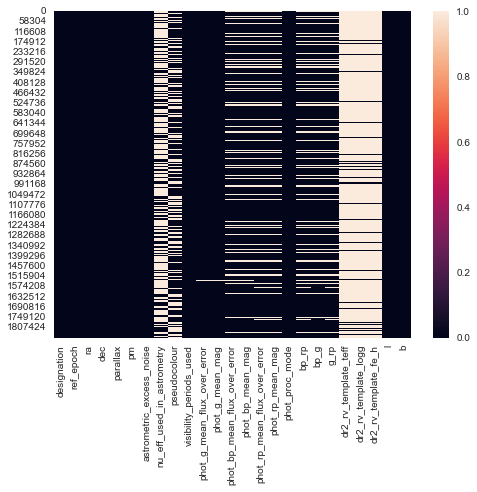

In [13]:
# Verificando se existe dados nulos ou NAN

plt.figure(figsize=(8,6))
sns.heatmap(stars_data.isnull())
plt.show()

-> Vemos que: template_teff, template_logg, e template_fe_h, possuem muitos dados faltantes, logo eliminaremos essas colunas. 

-> Os dados nulos da coluna 'nu_eff_used_in_astrometry' serão completados pelos valores de 'pseudocolor', que é o valor estimado.

-> Os dados faltantes dos 'flux_over_error' serão deletados, assim como as medidas de fluxo das respectivas bandas, e os outros dados que dependem deles, como por exemplo: 'bc_rp'. Eles não farão falta, pois, temos uma grande quantidade de dados.

In [14]:
# Conferindo a data e a qualidade dos dados

print(stars_data['ref_epoch'].value_counts())
print(stars_data['phot_proc_mode'].value_counts())

2016.0    1865726
Name: ref_epoch, dtype: int64
0.0    1558738
2.0     189955
1.0     115298
Name: phot_proc_mode, dtype: int64


**Usaremos os seguintes critérios para a filtragem dos dados:**

-> phot_proc_mode < 2

-> visibility_periods_used > 8

-> astrometric_excess_noise < 1

-> phot_g_mean_flux_over_error > 50

-> phot_bp_mean_flux_over_error > 20

-> phot_rp_mean_flux_over_error > 20

In [15]:
# Preenchendo os linhas faltantes de 'nu_eff_used_in_astrometry'.

stars_data['nu_eff_used_in_astrometry'].fillna(axis=0, value=stars_data['pseudocolour'],inplace=True)

#Filtrando os dados.

data_filter = stars_data['phot_proc_mode']<2
stars_data = stars_data[data_filter]
data_filter2 = stars_data['visibility_periods_used']>8
stars_data = stars_data[data_filter2]
data_filter3 = stars_data['astrometric_excess_noise']<1
stars_data = stars_data[data_filter3]
data_filter4 = stars_data['phot_g_mean_flux_over_error']>50
stars_data = stars_data[data_filter4]
data_filter5 = stars_data['phot_bp_mean_flux_over_error']>20
stars_data = stars_data[data_filter5]
data_filter6 = stars_data['phot_rp_mean_flux_over_error']>20
stars_data = stars_data[data_filter6]

stars_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 633774 entries, 1 to 1865725
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   designation                   633774 non-null  object 
 1   ref_epoch                     633774 non-null  float64
 2   ra                            633774 non-null  float64
 3   dec                           633774 non-null  float64
 4   parallax                      633774 non-null  float64
 5   pm                            633774 non-null  float64
 6   astrometric_excess_noise      633774 non-null  float64
 7   nu_eff_used_in_astrometry     633774 non-null  float64
 8   pseudocolour                  43885 non-null   float64
 9   visibility_periods_used       633774 non-null  int64  
 10  phot_g_mean_flux_over_error   633774 non-null  float64
 11  phot_g_mean_mag               633774 non-null  float64
 12  phot_bp_mean_flux_over_error  633774 non-nu

**Com os dados devidamente filtrados, é hora de eliminar as colunas que só serviam para a filtragem dos dados e as que possuem
muitos dados faltantes.**

In [16]:
# Eliminando as colunas desnecessárias.

stars_data = stars_data.drop(columns=['ref_epoch','dr2_rv_template_teff','phot_proc_mode','dr2_rv_template_logg',
                                      'dr2_rv_template_fe_h','dr2_rv_template_teff','pseudocolour','phot_g_mean_flux_over_error',
                                      'phot_bp_mean_flux_over_error','phot_rp_mean_flux_over_error','astrometric_excess_noise',
                                      'visibility_periods_used'])
stars_data.dropna(axis=0, how='any', inplace=True)
stars_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 633774 entries, 1 to 1865725
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   designation                633774 non-null  object 
 1   ra                         633774 non-null  float64
 2   dec                        633774 non-null  float64
 3   parallax                   633774 non-null  float64
 4   pm                         633774 non-null  float64
 5   nu_eff_used_in_astrometry  633774 non-null  float64
 6   phot_g_mean_mag            633774 non-null  float64
 7   phot_bp_mean_mag           633774 non-null  float64
 8   phot_rp_mean_mag           633774 non-null  float64
 9   bp_rp                      633774 non-null  float64
 10  bp_g                       633774 non-null  float64
 11  g_rp                       633774 non-null  float64
 12  l                          633774 non-null  float64
 13  b                          6

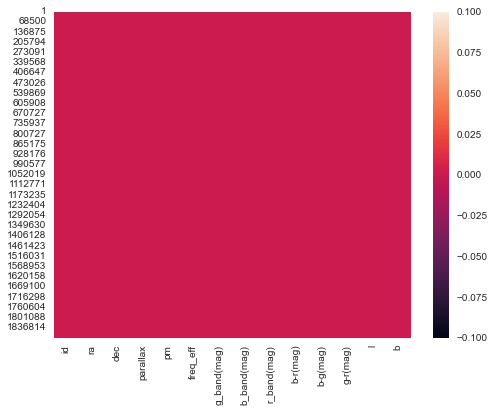

In [17]:
# Renomeando as colunas.

stars_data = stars_data.rename(columns={'designation': 'id', 'nu_eff_used_in_astrometry': 'freq_eff',
                              'phot_g_mean_mag': 'g_band(mag)','phot_bp_mean_mag': 'b_band(mag)',
                              'phot_rp_mean_mag': 'r_band(mag)','bp_rp': 'b-r(mag)','bp_g': 'b-g(mag)','g_rp': 'g-r(mag)'})

#Cria um arquivo csv com o dataframe.

stars_data.to_csv('stars_data.txt',index = False, header=True, sep=' ')

# Verificando se o dataframe está completo.

plt.figure(figsize=(8,6))
sns.heatmap(stars_data.isnull())
plt.show()

**Agora não temos nenhum dado faltante!**

In [18]:
stars = pd.read_csv('stars_data.txt', sep = ' ')
stars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633774 entries, 0 to 633773
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           633774 non-null  object 
 1   ra           633774 non-null  float64
 2   dec          633774 non-null  float64
 3   parallax     633774 non-null  float64
 4   pm           633774 non-null  float64
 5   freq_eff     633774 non-null  float64
 6   g_band(mag)  633774 non-null  float64
 7   b_band(mag)  633774 non-null  float64
 8   r_band(mag)  633774 non-null  float64
 9   b-r(mag)     633774 non-null  float64
 10  b-g(mag)     633774 non-null  float64
 11  g-r(mag)     633774 non-null  float64
 12  l            633774 non-null  float64
 13  b            633774 non-null  float64
dtypes: float64(13), object(1)
memory usage: 67.7+ MB


**Essa tática de criar um arquivo com o dataframe e ler de novo foi feita para termos o índice em ordem novamente(deve ter outro jeito!).**

In [19]:
# Removendo as os caracteres 'Gaia EDR3 ' do ID para fundir com outros dataframes no futuro.

stars.replace({'Gaia EDR3 ': ''}, regex=True, inplace=True)
stars.head()

,id,ra,dec,parallax,pm,freq_eff,g_band(mag),b_band(mag),r_band(mag),b-r(mag),b-g(mag),g-r(mag),l,b
0,3781327832039804160,157.523249,-2.591879,7.000003,36.325535,1.257106,16.742850,18.309256,15.539074,2.770182,1.566406,1.203775,248.413311,44.802440
1,160105836651833600,73.620428,31.499510,7.000007,49.957104,1.266479,16.211855,17.729303,15.016982,2.712321,1.517448,1.194873,171.575869,-7.609054
2,2882530608807142528,90.497362,-40.171223,7.000009,29.450960,1.369841,13.711228,14.595704,12.785631,1.810073,0.884476,0.925597,246.723454,-26.087072
3,3829652501951933312,151.068280,-1.861213,7.000010,28.138224,1.228052,16.266370,17.440048,14.563461,2.876587,1.173677,1.702910,241.898430,40.420782
4,5675763517472966016,138.797126,-22.494523,7.000010,38.404530,1.307066,15.134747,16.351723,14.042218,2.309505,1.216976,1.092528,251.089407,17.947132


In [20]:
# Criando um arquivo com o ID sem os caracteres 'Gaia EDR3 '.
stars.to_csv('stars_ggdrless.txt',index = False, header=True, sep=' ')

## Dados externos do GAIA (Distância).

In [12]:
# Transformando as tabelas astropy em dataframe.

stars_distance = pd.DataFrame()
stars_distance['id'] = results['source_id']
stars_distance['distance(pc)'] = results['r_med_geo']
stars_distance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            10000 non-null  int64  
 1   distance(pc)  10000 non-null  float32
dtypes: float32(1), int64(1)
memory usage: 117.3 KB


In [13]:
stars_distance['id'] = stars_distance['id'].astype(str)
stars_distance

,id,distance(pc)
0,5853498713190525696,1.301911
1,4472832130942575872,1.828106
2,3864972938605115520,2.408358
3,762815470562110464,2.545952
4,2947050466531873024,2.670147
...,...,...
9995,6789616006690405632,30.649437
9996,1030516968191117440,30.649466
9997,4319092647002433024,30.649961
9998,1505311446553172992,30.650242


# Análise exploratória.

In [14]:
# Carregando o arquivo de dados com o ID sem o ggdr3

stars = pd.read_csv('stars_ggdrless.txt',sep=' ')


stars_distance['id'] = stars_distance['id'].astype(str)
stars['id'] = stars['id'].astype(str)


full_dataset = pd.merge(stars_distance, stars, how = 'inner', on = 'id')

full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7616 entries, 0 to 7615
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            7616 non-null   object 
 1   distance(pc)  7616 non-null   float32
 2   ra            7616 non-null   float64
 3   dec           7616 non-null   float64
 4   parallax      7616 non-null   float64
 5   pm            7616 non-null   float64
 6   freq_eff      7616 non-null   float64
 7   g_band(mag)   7616 non-null   float64
 8   b_band(mag)   7616 non-null   float64
 9   r_band(mag)   7616 non-null   float64
 10  b-r(mag)      7616 non-null   float64
 11  b-g(mag)      7616 non-null   float64
 12  g-r(mag)      7616 non-null   float64
 13  l             7616 non-null   float64
 14  b             7616 non-null   float64
dtypes: float32(1), float64(13), object(1)
memory usage: 922.2+ KB


In [15]:
full_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
distance(pc),7616.0,22.945141,5.906645,1.301911,19.271043,24.166409,27.730609,30.650257
ra,7616.0,181.537720,103.711232,0.145801,91.158980,182.460464,272.084774,359.967810
dec,7616.0,-0.174757,39.438068,-87.764785,-31.103234,0.004152,29.900570,89.440939
parallax,7616.0,48.974492,26.808153,32.572307,36.025472,41.344455,51.854477,768.066539
pm,7616.0,399.639478,433.679160,0.428037,175.887618,297.143060,490.858725,10393.349000
freq_eff,7616.0,1.324535,0.132778,0.981454,1.238092,1.277870,1.378085,1.878053
g_band(mag),7616.0,11.895872,2.804942,2.804179,10.297552,12.296052,13.900647,18.909670
b_band(mag),7616.0,13.222779,3.293070,3.675863,11.382253,13.711563,15.553454,20.588072
r_band(mag),7616.0,10.832022,2.639578,2.376140,9.236899,11.096932,12.664069,18.236105
b-r(mag),7616.0,2.390757,0.977861,-0.373055,1.774283,2.568374,3.006378,5.201105


In [16]:
full_dataset['absmag(g)'] = full_dataset['g_band(mag)']+5-(5*np.log10(full_dataset['distance(pc)']))
full_dataset['absmag(r)'] = full_dataset['r_band(mag)']+5-(5*np.log10(full_dataset['distance(pc)']))
full_dataset['absmag(b)'] = full_dataset['b_band(mag)']+5-(5*np.log10(full_dataset['distance(pc)']))



full_dataset = full_dataset.drop(columns=['id','g_band(mag)','r_band(mag)','b_band(mag)'])


full_dataset.head(15)


,distance(pc),ra,dec,parallax,pm,freq_eff,b-r(mag),b-g(mag),g-r(mag),l,b,absmag(g),absmag(r),absmag(b)
0,1.301911,217.392321,-62.676075,768.066539,3859.2280,1.140833,3.804580,2.388367,1.416214,313.925496,-1.917754,13.411842,11.995628,15.800209
1,1.828106,269.448503,4.739420,546.975940,10393.3490,1.257181,2.833697,1.597814,1.235883,31.049418,14.086604,11.883967,10.648084,13.481781
2,2.408358,164.103190,7.002727,415.179416,4715.3296,1.088607,4.184836,2.731895,1.452941,244.051151,56.098853,14.129785,12.676844,16.861681
3,2.545952,165.830960,35.948653,392.752945,4811.6800,1.297933,2.215609,1.139950,1.075659,185.169510,65.433988,9.521921,8.446262,10.661871
4,2.975431,282.458789,-23.837097,336.026602,668.1399,1.256002,2.834036,1.605769,1.228267,11.307625,-10.287476,11.758665,10.530398,13.364434
5,3.159211,355.480015,44.170376,316.481187,1595.6226,1.204241,3.529414,2.167150,1.362264,109.989338,-16.947350,12.881384,11.519121,15.048535
6,3.287725,346.503917,-35.847164,304.135369,6895.5312,1.332832,2.098285,1.067759,1.030526,5.097226,-65.987693,8.937555,7.907028,10.005314
7,3.374221,176.937688,0.799120,296.305308,1365.5074,1.238261,3.033258,1.760026,1.273232,270.156916,59.555659,11.960132,10.686899,13.720158
8,3.496067,316.753663,38.756073,286.005352,5178.7075,1.386976,1.715341,0.821609,0.893732,82.339880,-5.830396,7.732746,6.839014,8.554354
9,3.496246,316.748479,38.763862,285.994948,5282.1040,1.388744,1.462590,0.673080,0.789510,82.342974,-5.822177,7.048703,6.259193,7.721783


In [17]:
full_dataset['theta'] = full_dataset['dec']
for r in range(len(full_dataset)):
    if full_dataset['dec'][r] < 0:
        full_dataset['theta'][r] = np.abs(full_dataset['dec'][r]) + 90
    else:
        full_dataset['theta'][r] = 90 - full_dataset['dec'][r]
        
full_dataset['theta_rad'] = (full_dataset['theta']*np.pi)/180
full_dataset['phi_rad'] = (full_dataset['ra']*np.pi)/180

full_dataset[['dec', 'theta', 'theta_rad','ra', 'phi_rad']].head(10) 
    

C:\Users\Diego\AppData\Local\Temp/ipykernel_12832/3839171702.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_dataset['theta'][r] = np.abs(full_dataset['dec'][r]) + 90
C:\Users\Diego\AppData\Local\Temp/ipykernel_12832/3839171702.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_dataset['theta'][r] = 90 - full_dataset['dec'][r]


,dec,theta,theta_rad,ra,phi_rad
0,-62.676075,152.676075,2.664700,217.392321,3.794212
1,4.739420,85.260580,1.488078,269.448503,4.702764
2,7.002727,82.997273,1.448576,164.103190,2.864141
3,35.948653,54.051347,0.943374,165.830960,2.894296
4,-23.837097,113.837097,1.986832,282.458789,4.929836
5,44.170376,45.829624,0.799878,355.480015,6.204297
6,-35.847164,125.847164,2.196447,346.503917,6.047634
7,0.799120,89.200880,1.556849,176.937688,3.088145
8,38.756073,51.243927,0.894375,316.753663,5.528394
9,38.763862,51.236138,0.894239,316.748479,5.528304


In [19]:

full_dataset['x'] = full_dataset['distance(pc)']*np.cos(full_dataset['phi_rad'])*np.sin(full_dataset['theta_rad']);
full_dataset['y'] = full_dataset['distance(pc)']*np.sin(full_dataset['phi_rad'])*np.sin(full_dataset['theta_rad']);
full_dataset['z'] = full_dataset['distance(pc)']*np.cos(full_dataset['theta_rad']);

full_dataset[['ra','dec','theta','theta_rad', 'phi_rad', 'x', 'y', 'z']].head(10)

,ra,dec,theta,theta_rad,phi_rad,x,y,z
0,217.392321,-62.676075,152.676075,2.664700,3.794212,-0.474794,-0.362907,-1.156651
1,269.448503,4.739420,85.260580,1.488078,4.702764,-0.017536,-1.821771,0.151046
2,164.103190,7.002727,82.997273,1.448576,2.864141,-2.298976,0.654742,0.293619
3,165.830960,35.948653,54.051347,0.943374,2.894296,-1.998356,0.504513,1.494626
4,282.458789,-23.837097,113.837097,1.986832,4.929836,0.587155,-2.657531,-1.202484
5,355.480015,44.170376,45.829624,0.799878,6.204297,2.258963,-0.178577,2.201320
6,346.503917,-35.847164,125.847164,2.196447,6.047634,2.591380,-0.621948,-1.925375
7,176.937688,0.799120,89.200880,1.556849,3.088145,-3.369075,0.180240,0.047060
8,316.753663,38.756073,51.243927,0.894375,5.528394,1.985875,-1.867885,2.188560
9,316.748479,38.763862,51.236138,0.894239,5.528304,1.985590,-1.867956,2.189042


In [20]:
full_dataset = full_dataset.drop(columns=['ra','dec','theta','theta_rad','phi_rad'])

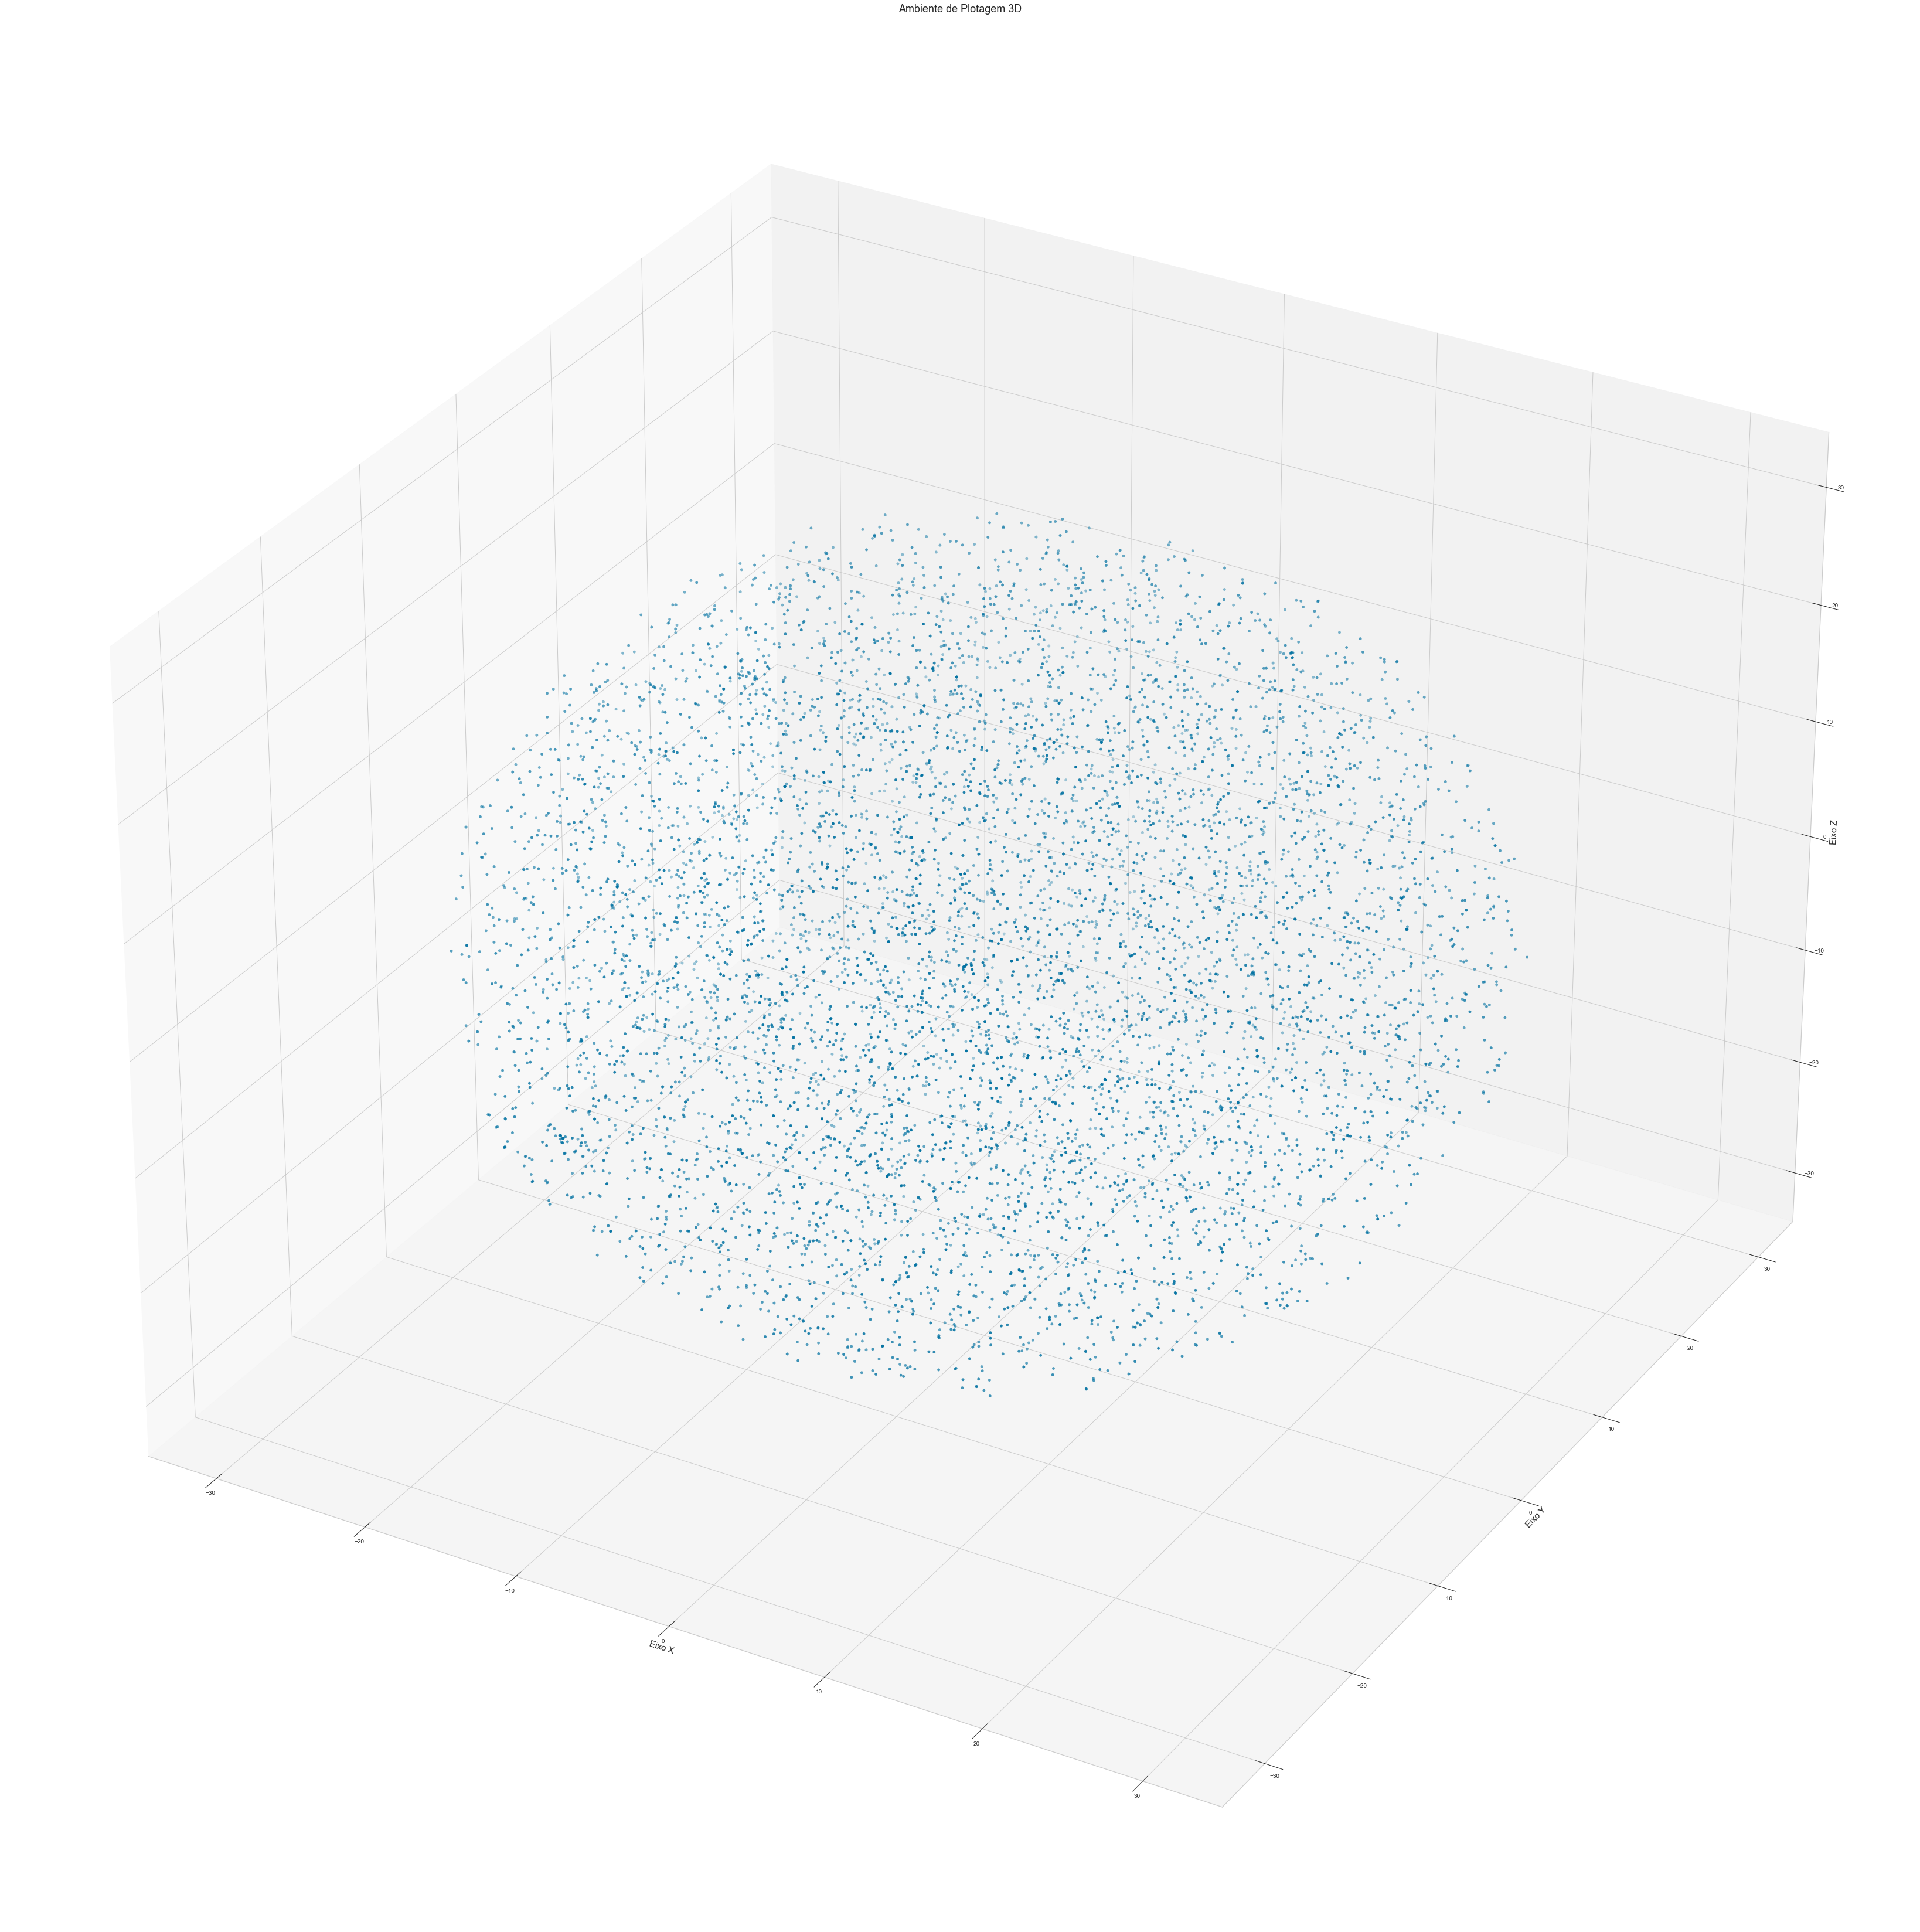

In [30]:

fig  = plt.figure(figsize=(80, 60))
ax = plt.axes(projection="3d")
ax.set_title('Ambiente de Plotagem 3D', fontsize=18)
ax.set_xlabel('Eixo X', fontsize=15)
ax.set_ylabel('Eixo Y', fontsize=15)
ax.set_zlabel('Eixo Z', fontsize=15)
ax.scatter(full_dataset['x'], full_dataset['y'], full_dataset['z'], 'purple')

plt.show()

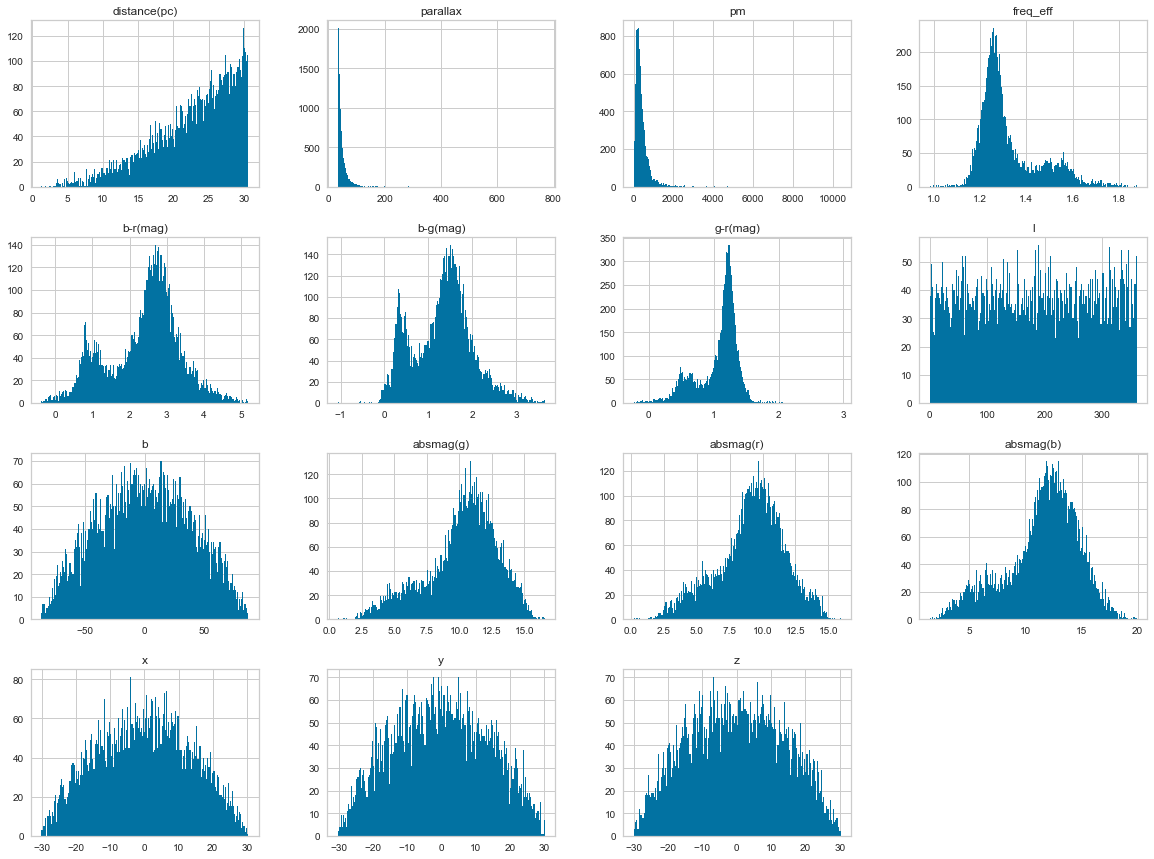

In [31]:
%matplotlib inline
full_dataset.hist(figsize=(20,15), bins=200)
plt.show()

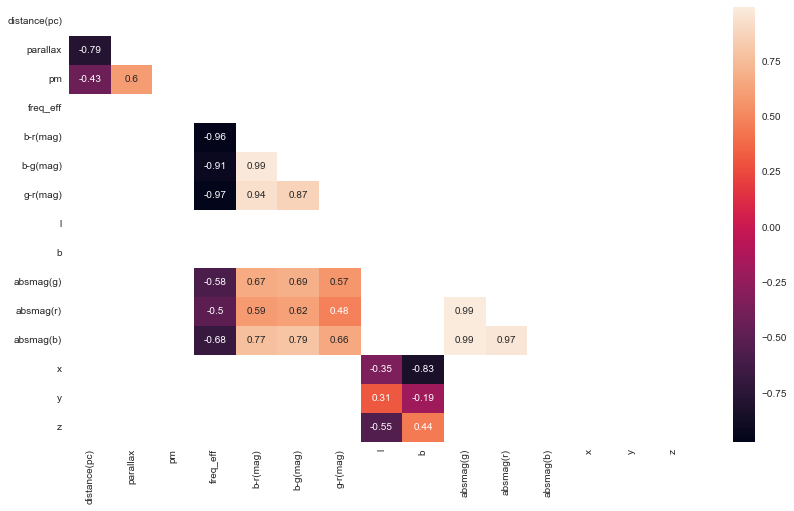

In [32]:
%matplotlib inline
plt.figure(figsize=(14, 8))
corr=full_dataset.corr()
mask = np.triu(np.ones_like(corr, dtype=bool));
sns.heatmap(corr[(corr > .1) | (corr < -.1)], annot = True, mask = mask);
#sns.heatmap(full_dataset.corr(),vmin = -1, vmax = +1, annot = True)
plt.show()

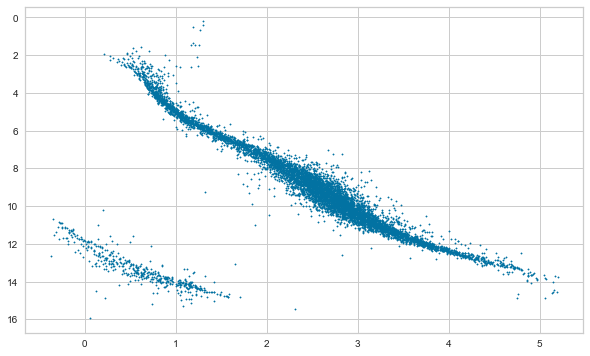

In [33]:
f, ax = plt.subplots(figsize=(10,6))
plt.scatter(x=full_dataset['b-r(mag)'], y=full_dataset['absmag(r)'], s=2)
'''

sns.scatterplot(x='bp_gp',y='phot_g_mean_mag',data=stars_data,palette='dark')'''
ax.invert_yaxis()

In [34]:
# Descritive numerical statistics 

df = pd.DataFrame()

df_min = full_dataset.min()
df_max = full_dataset.max()
df_range = full_dataset.max() - full_dataset.min()
df_mean = full_dataset.mean()
df_std = full_dataset.std()
df_skew = full_dataset.skew()
df_kurtosis = full_dataset.kurtosis()

df_description = pd.concat([df_min, df_max, df_range, df_mean, df_std, df_skew, df_kurtosis], axis = 1).round(2)
df_description.columns = ['min', 'max', 'range', 'mean', 'std', 'skew', 'kurtosis']
df_description

,min,max,range,mean,std,skew,kurtosis
distance(pc),1.30,30.65,29.35,22.95,5.91,-0.86,0.14
parallax,32.57,768.07,735.49,48.97,26.81,7.34,111.37
pm,0.43,10393.35,10392.92,399.64,433.68,6.86,92.96
freq_eff,0.98,1.88,0.90,1.32,0.13,1.24,1.07
b-r(mag),-0.37,5.20,5.57,2.39,0.98,-0.32,-0.22
b-g(mag),-1.07,3.64,4.71,1.33,0.68,0.14,-0.10
g-r(mag),-0.24,2.96,3.20,1.06,0.33,-1.01,1.17
l,0.02,359.97,359.95,181.52,104.62,-0.01,-1.21
b,-87.10,87.83,174.93,0.26,38.92,0.00,-0.79
absmag(g),0.64,16.54,15.90,10.19,2.75,-0.63,-0.00


In [35]:

coo = pd.DataFrame()

coo['x'] =full_dataset['x']
coo['y'] =full_dataset['y']
coo['z'] =full_dataset['z']
coo['b'] =full_dataset['b']
coo['l'] =full_dataset['l']

coo

,x,y,z,b,l
0,-0.474794,-0.362907,-1.156651,-1.917754,313.925496
1,-0.017536,-1.821771,0.151046,14.086604,31.049418
2,-2.298976,0.654742,0.293619,56.098853,244.051151
3,-1.998356,0.504513,1.494626,65.433988,185.169510
4,0.587155,-2.657531,-1.202484,-10.287476,11.307625
...,...,...,...,...,...
7611,-23.835318,-0.611696,-19.248490,23.105749,293.315271
7612,22.926757,14.773982,13.972740,-32.460132,144.013385
7613,-3.849094,-15.224668,26.319940,36.794216,88.191638
7614,20.934353,-17.082445,-14.468273,-44.226032,18.957458


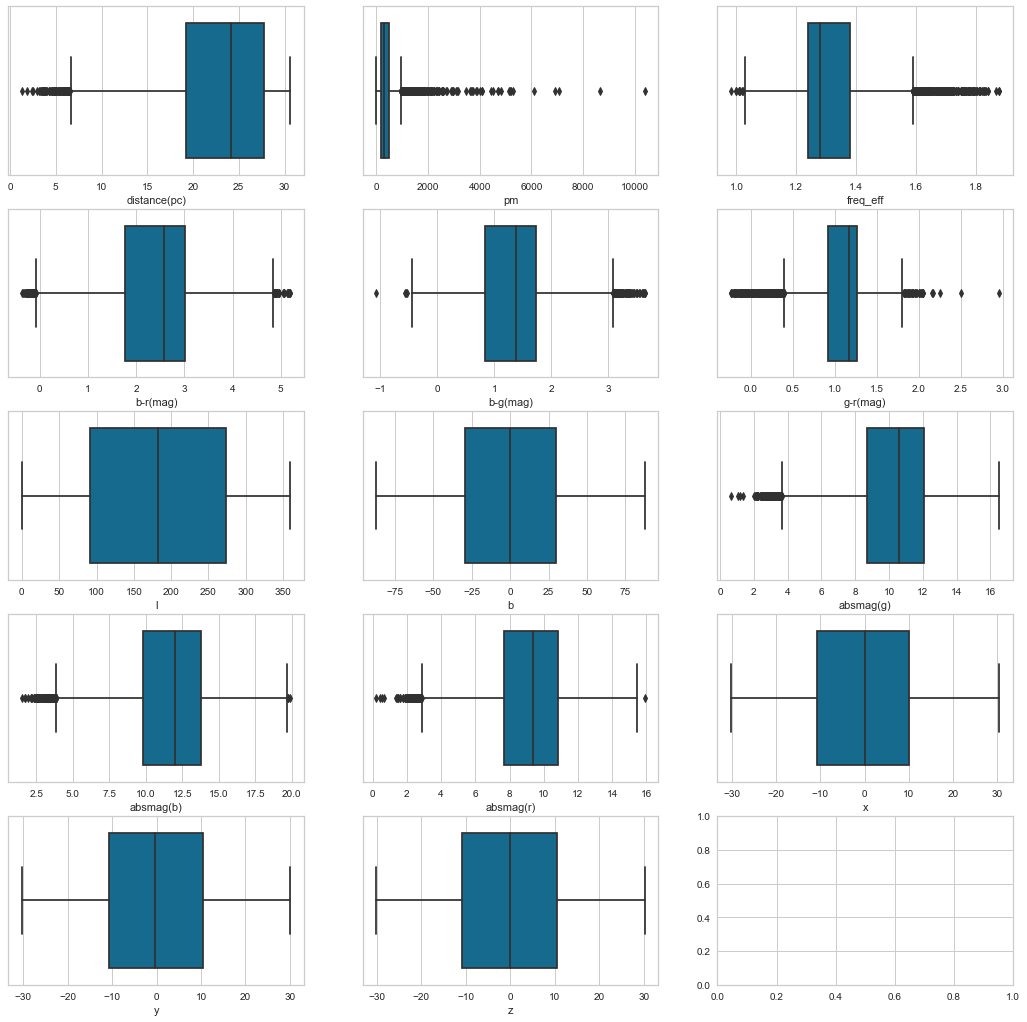

In [36]:
fig, axis = plt.subplots(5,3, figsize = (18,18))

sns.boxplot(data = full_dataset, x = 'distance(pc)', ax = axis[0,0]);
sns.boxplot(data = full_dataset, x = 'pm', ax = axis[0,1]);
sns.boxplot(data = full_dataset, x = 'freq_eff', ax = axis[0,2]);

sns.boxplot(data = full_dataset, x = 'b-r(mag)', ax = axis[1,0]);
sns.boxplot(data = full_dataset, x = 'b-g(mag)', ax = axis[1,1]);
sns.boxplot(data = full_dataset, x = 'g-r(mag)', ax = axis[1,2]);


sns.boxplot(data = full_dataset, x = 'l', ax = axis[2,0]);
sns.boxplot(data = full_dataset, x = 'b', ax = axis[2,1]);
sns.boxplot(data = full_dataset, x = 'absmag(g)', ax = axis[2,2]);

sns.boxplot(data = full_dataset, x = 'absmag(b)', ax = axis[3,0]);
sns.boxplot(data = full_dataset, x = 'absmag(r)', ax = axis[3,1]);
sns.boxplot(data = full_dataset, x = 'x', ax = axis[3,2]);

sns.boxplot(data = full_dataset, x = 'y', ax = axis[4,0]);
sns.boxplot(data = full_dataset, x = 'z', ax = axis[4,1]);





# 04 - Preparação dos dados para o modelo.

In [21]:
df_model = full_dataset.copy()

for col in df_model:
    stat, p = normaltest(df_model[col])
    print('stat: %.3f, p: %.3f' %(stat, p))
    if p > 0.05:
        print('{}: Probably Gaussian\n'.format(col))
    else:
        print('{}: Probably Not Gaussian\n'.format(col))

stat: 719.449, p: 0.000
distance(pc): Probably Not Gaussian

stat: 10161.015, p: 0.000
parallax: Probably Not Gaussian

stat: 9724.733, p: 0.000
pm: Probably Not Gaussian

stat: 1398.139, p: 0.000
freq_eff: Probably Not Gaussian

stat: 141.981, p: 0.000
b-r(mag): Probably Not Gaussian

stat: 28.712, p: 0.000
b-g(mag): Probably Not Gaussian

stat: 1098.571, p: 0.000
g-r(mag): Probably Not Gaussian

stat: 7208.718, p: 0.000
l: Probably Not Gaussian

stat: 622.091, p: 0.000
b: Probably Not Gaussian

stat: 422.886, p: 0.000
absmag(g): Probably Not Gaussian

stat: 208.732, p: 0.000
absmag(r): Probably Not Gaussian

stat: 384.396, p: 0.000
absmag(b): Probably Not Gaussian

stat: 708.125, p: 0.000
x: Probably Not Gaussian

stat: 795.696, p: 0.000
y: Probably Not Gaussian

stat: 965.477, p: 0.000
z: Probably Not Gaussian



In [22]:
mms = MinMaxScaler()
rs = RobustScaler()

In [23]:
# MinMaxScaler 
df_model['l'] = mms.fit_transform(df_model[['l']].values)
df_model['b'] = mms.fit_transform(df_model[['b']].values)
df_model['x'] = mms.fit_transform(df_model[['x']].values)
df_model['y'] = mms.fit_transform(df_model[['y']].values)
df_model['z'] = mms.fit_transform(df_model[['z']].values)


# RobustScaler
df_model['distance(pc)'] = rs.fit_transform(df_model[['distance(pc)']].values)
df_model['pm'] = rs.fit_transform(df_model[['pm']].values)
df_model['freq_eff'] = rs.fit_transform(df_model[['freq_eff']].values)
df_model['b-r(mag)'] = rs.fit_transform(df_model[['b-r(mag)']].values)
df_model['b-g(mag)'] = rs.fit_transform(df_model[['b-g(mag)']].values)
df_model['g-r(mag)'] = rs.fit_transform(df_model[['g-r(mag)']].values)
df_model['absmag(g)'] = rs.fit_transform(df_model[['absmag(g)']].values)
df_model['absmag(r)'] = rs.fit_transform(df_model[['absmag(r)']].values)
df_model['absmag(b)'] = rs.fit_transform(df_model[['absmag(b)']].values)

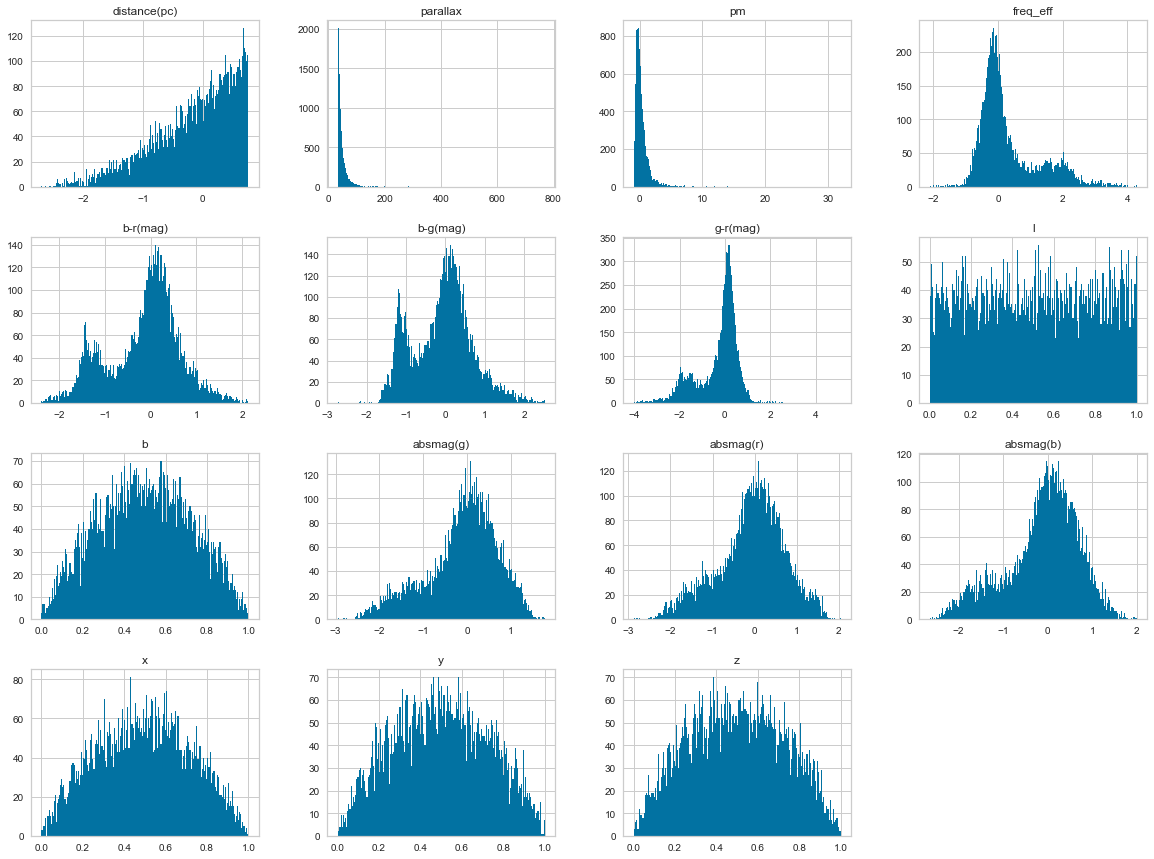

In [40]:
%matplotlib inline
df_model.hist(figsize=(20,15), bins=200)
plt.show()

In [24]:
df_model = df_model.drop(columns=['parallax','l'])

In [46]:
df_model = df_model.drop(columns=['pm'])

In [167]:
train_set

,freq_eff,x,y,z
201695,0.004582,0.349454,0.797866,0.824923
187007,-0.051853,0.913670,0.615228,0.352174
193746,-0.403629,0.408022,0.638776,0.070062
58834,-0.396192,0.237953,0.366112,0.427603
9894,2.031268,0.641881,0.436277,0.558464
...,...,...,...,...
119879,-0.231756,0.800388,0.743290,0.531157
103694,-0.135767,0.438066,0.170765,0.655173
131932,2.204322,0.380021,0.839830,0.323052
146867,1.489826,0.507690,0.175061,0.761007


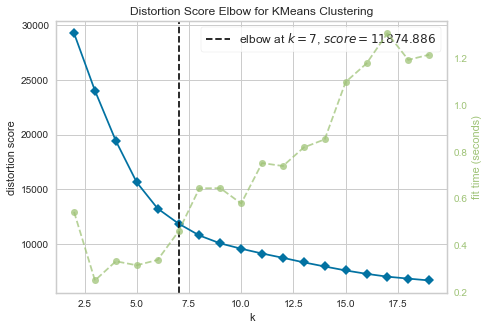

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
plt.figure(figsize=(7,5))
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20))
visualizer.fit(train_set)
visualizer.show()

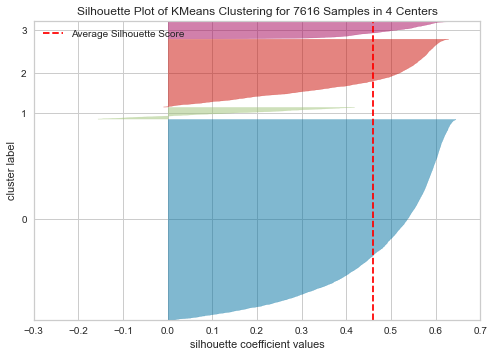

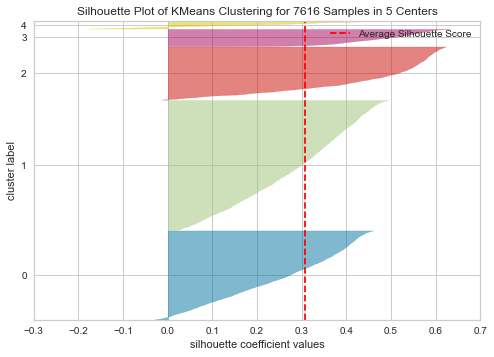

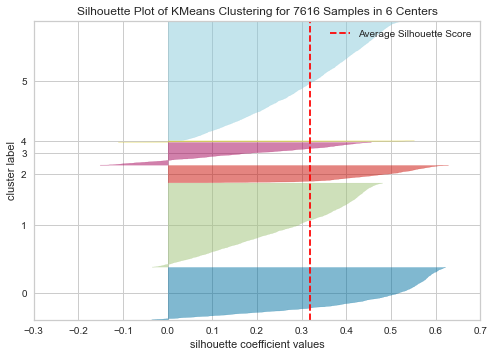

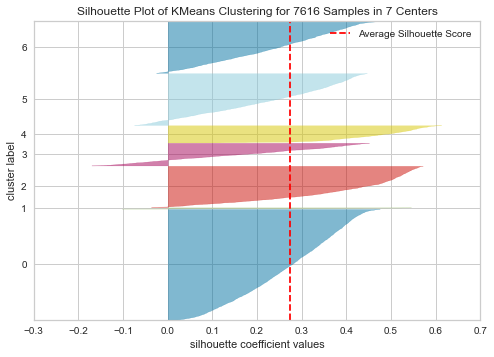

In [39]:
c3 = silhouette_visualizer(KMeans(4, random_state=42), df_model, colors='yellowbrick')
c0 =silhouette_visualizer(KMeans(5, random_state=42), df_model, colors='yellowbrick')
c1 =silhouette_visualizer(KMeans(6, random_state=42), df_model, colors='yellowbrick')
c2 = silhouette_visualizer(KMeans(7, random_state=42), df_model, colors='yellowbrick')

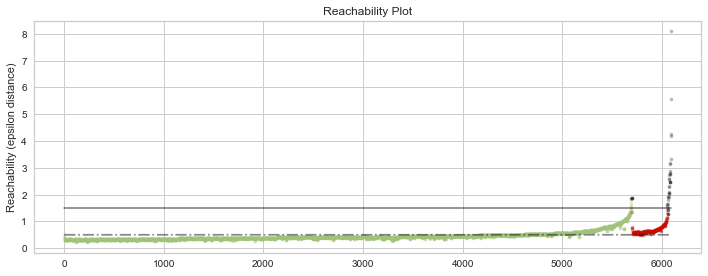

In [37]:

clust = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)

# Run the fit
clust.fit(train_set)


space = np.arange(len(train_set))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 4))
G = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(G[0, :])



# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 1.5, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")


plt.tight_layout()
plt.show()

In [32]:
 from sklearn.cluster import AgglomerativeClustering
aux = full_dataset.copy()
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(train_set)
clustering
labels = clustering.labels_
aux['label'] = labels

In [27]:
sns.relplot(
    data=aux,
    x="b-g(mag)", y="absmag(g)",
    hue="label",palette='tab10'
)

ValueError: Image size of 407x106656 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 418.5x360 with 1 Axes>

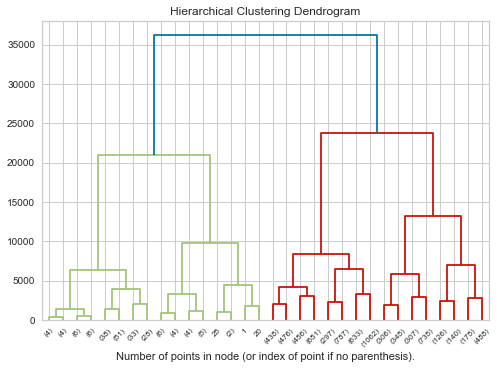

In [33]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


# Usaremos também o modelo de mistura gaussiana com os mesmos parâmetros do kmeans

In [29]:
train_set, test_set = train_test_split(df_model, test_size=0.2, random_state=42)
print(len(train_set), 'train + ', len(test_set), 'test')

6092 train +  1524 test


# Modelos.

In [30]:
train_set

,distance(pc),pm,freq_eff,b-r(mag),b-g(mag),g-r(mag),b,absmag(g),absmag(r),absmag(b),x,y,z
4054,0.069515,-0.415967,-0.554873,0.715847,0.732038,0.668355,0.539891,0.874782,0.857177,0.906143,0.441514,0.870559,0.666893
3011,-0.203699,-0.471961,-0.119065,0.143515,0.166249,0.103473,0.496900,0.026496,0.024206,0.056236,0.373047,0.340602,0.187176
6355,0.548800,-0.767569,1.422323,-1.121822,-0.974243,-1.428071,0.534839,-1.275529,-1.181473,-1.309879,0.593352,0.046443,0.601302
4747,0.226125,-0.594885,2.474025,-1.638707,-1.317646,-2.367381,0.869935,-2.192464,-2.045823,-2.167848,0.153701,0.261675,0.595704
6312,0.539184,0.661242,0.061128,-0.053738,-0.039272,-0.064265,0.445851,-0.213975,-0.211090,-0.194914,0.537035,0.106750,0.236393
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,0.330543,0.072659,1.050785,-0.890638,-0.792143,-1.080962,0.002184,-1.019006,-0.948905,-1.050374,0.882617,0.613064,0.305042
5390,0.362146,-0.015382,0.015925,0.017894,-0.006597,0.104108,0.195147,-0.134569,-0.145776,-0.119949,0.942787,0.485479,0.553168
860,-1.089906,2.937002,0.095177,-0.104589,-0.088604,-0.116854,0.790368,-0.035388,-0.016927,-0.054124,0.359052,0.311528,0.573787
7603,0.764307,-0.360763,-0.210500,0.282743,0.254526,0.367296,0.672966,0.323696,0.308816,0.329110,0.156116,0.198508,0.279984


In [31]:
train_data = train_set.to_numpy()
test_data = test_set.to_numpy()

In [215]:

gm6 = GaussianMixture(n_components=6, random_state=42).fit(train_data)
gm5 = GaussianMixture(n_components=5, random_state=42).fit(train_data)

In [216]:
kmeans6 = KMeans(init="random",n_clusters=6,n_init=10,random_state=42 ).fit(train_data)
kmeans5 = KMeans(init="random",n_clusters=6,n_init=10,random_state=42 ).fit(train_data)

array([3, 2, 0, ..., 3, 3, 5], dtype=int64)

In [229]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics


af = AffinityPropagation(random_state=42).fit(train_data)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print("Estimated number of clusters: %d" % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(train_data, labels, metric="sqeuclidean")
)

Estimated number of clusters: 128


NameError: name 'labels_true' is not defined

In [217]:
ts = test_data.copy()

In [218]:
t_s = pd.DataFrame(ts, columns=test_set.columns)
t_s['class'] = gm.predict(test_data)

In [113]:
t_s['g'] = g['g']
t_s

NameError: name 'g' is not defined

<Figure size 1440x720 with 0 Axes>

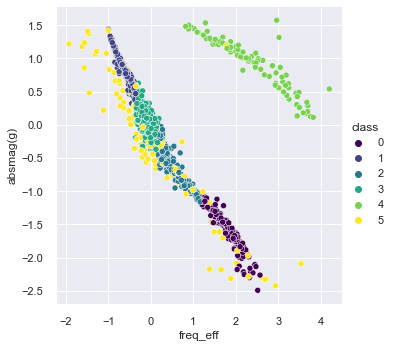

In [219]:
plt.figure(figsize=(20,10))
sns.relplot(
    data=t_s,
    x="freq_eff", y="absmag(g)",
    hue="class", palette='viridis'
)
sns.set(rc={'figure.figsize':(20,16)})

In [44]:
from sklearn.cluster import KMeans

kmeans = KMeans(
            init="random",
            n_clusters=5,
            n_init=10,
            random_state=10 )

In [45]:
kmeans.fit(train_data)

NameError: name 'train_data' is not defined

In [222]:
kmeans.predict(test_data)

array([5, 0, 2, ..., 4, 5, 3])

In [223]:
ts = test_data.copy()

In [224]:
t_s = pd.DataFrame(ts, columns=test_set.columns)
t_s['class'] = kmeans.predict(test_data)

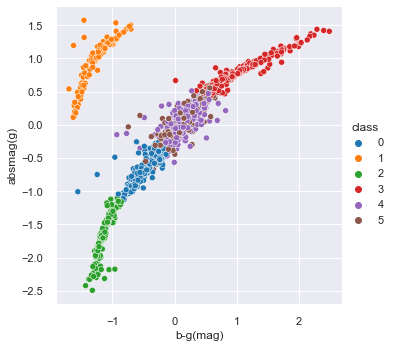

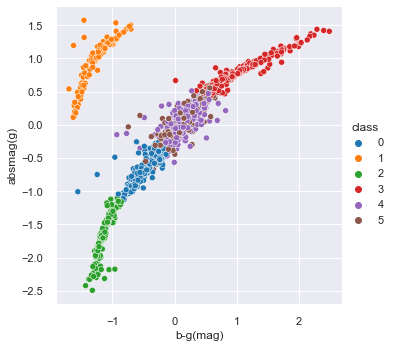

In [226]:
sns.relplot(
    data=t_s,
    x="b-g(mag)", y="absmag(g)",
    hue="class",palette='tab10'
)
sns.relplot(
    data=t_s,
    x="b-g(mag)", y="absmag(g)",
    hue="class",palette='tab10'
)

In [270]:
ptt = pd.read_csv('gaia_model-result.csv')
#y['ra']=y['_RAJ2000']
#y['ra'].round(4)
#pt['ra'] = s['ra'].astype(str)
ptt.dropna(axis=0, how='any', inplace=True)
ptt.info()
ptt

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443528 entries, 0 to 1791604
Data columns (total 13 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   ra                    1443528 non-null  float64
 1   barycentric_distance  1443528 non-null  float64
 2   v_i                   1443528 non-null  float64
 3   mean_absolute_v       1443528 non-null  float64
 4   teff                  1443528 non-null  float64
 5   spectral_type         1443528 non-null  object 
 6   logg                  1443528 non-null  float64
 7   feh                   1443528 non-null  float64
 8   mbol                  1443528 non-null  float64
 9   age                   1443528 non-null  float64
 10  mass                  1443528 non-null  float64
 11  radius                1443528 non-null  float64
 12  population            1443528 non-null  int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 154.2+ MB


,ra,barycentric_distance,v_i,mean_absolute_v,teff,spectral_type,logg,feh,mbol,age,mass,radius,population
0,353.725335,144.74161,1.233,7.75,4295.3643,K5V,4.677,0.032990,7.11,8.5,0.640,0.606249,1
1,353.725417,144.73785,0.999,15.07,5093.3090,DAVII,8.030,0.032990,14.83,8.5,0.600,0.012321,1
3,65.791934,78.56313,2.280,11.55,3443.4993,M2V,4.987,-0.498293,9.75,8.5,0.280,0.279674,1
4,8.067447,182.41447,1.165,7.42,4477.1330,K4.5V,4.666,0.125812,6.87,8.5,0.661,0.623234,1
5,8.067437,182.41454,2.083,11.84,3475.3616,M2V,5.093,0.125812,10.34,8.5,0.200,0.209243,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1791599,277.817924,195.51306,1.869,10.00,3767.0380,M1V,4.915,-0.767987,8.75,10.0,0.409,0.370383,2
1791600,161.184867,100.14810,1.010,0.76,4742.4200,G9III,2.614,-0.030998,0.38,1.5,1.882,11.031925,1
1791601,161.184502,100.14981,1.171,7.00,4570.8820,K4V,4.605,-0.030998,6.43,1.5,0.809,0.732236,1
1791603,13.905215,178.62822,1.060,7.20,4655.8610,K4V,4.678,-0.041322,6.73,10.0,0.662,0.614683,2


In [268]:
stt = pd.read_csv('stars_ggdrless.txt', sep= ' ')
#s['id'] = s['source_id']
#s['id'] = s['id'].astype(str)
#s['ra'].round(4)
#s['ra'] = s['ra'].astype(str)
stt

,id,ra,dec,parallax,pm,freq_eff,g_band(mag),b_band(mag),r_band(mag),b-r(mag),b-g(mag),g-r(mag),l,b
0,3781327832039804160,157.523249,-2.591879,7.000003,36.325535,1.257106,16.742850,18.309256,15.539074,2.770182,1.566406,1.203775,248.413311,44.802440
1,160105836651833600,73.620428,31.499510,7.000007,49.957104,1.266479,16.211855,17.729303,15.016982,2.712321,1.517448,1.194873,171.575869,-7.609054
2,2882530608807142528,90.497362,-40.171223,7.000009,29.450960,1.369841,13.711228,14.595704,12.785631,1.810073,0.884476,0.925597,246.723454,-26.087072
3,3829652501951933312,151.068280,-1.861213,7.000010,28.138224,1.228052,16.266370,17.440048,14.563461,2.876587,1.173677,1.702910,241.898430,40.420782
4,5675763517472966016,138.797126,-22.494523,7.000010,38.404530,1.307066,15.134747,16.351723,14.042218,2.309505,1.216976,1.092528,251.089407,17.947132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633769,4075141768785646848,282.458789,-23.837097,336.026602,668.139900,1.256002,9.126414,10.732183,7.898147,2.834036,1.605769,1.228267,11.307625,-10.287476
633770,762815470562110464,165.830960,35.948653,392.752945,4811.680000,1.297933,6.551172,7.691122,5.475513,2.215609,1.139950,1.075659,185.169510,65.433988
633771,3864972938605115520,164.103190,7.002727,415.179416,4715.329600,1.088607,11.038391,13.770287,9.585450,4.184836,2.731895,1.452941,244.051151,56.098853
633772,4472832130942575872,269.448503,4.739420,546.975940,10393.349000,1.257181,8.193974,9.791788,6.958091,2.833697,1.597814,1.235883,31.049418,14.086604


In [269]:
pl = pd.merge(ptt, stt, how = 'inner', on = 'ra')
pl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ra                    0 non-null      float64
 1   barycentric_distance  0 non-null      float64
 2   v_i                   0 non-null      float64
 3   mean_absolute_v       0 non-null      float64
 4   teff                  0 non-null      float64
 5   spectral_type         0 non-null      object 
 6   logg                  0 non-null      float64
 7   feh                   0 non-null      float64
 8   mbol                  0 non-null      float64
 9   age                   0 non-null      float64
 10  mass                  0 non-null      float64
 11  radius                0 non-null      float64
 12  population            0 non-null      int64  
 13  id                    0 non-null      int64  
 14  dec                   0 non-null      float64
 15  parallax              0 non-null      fl

In [155]:
stars_full_dataset

,ra,barycentric_distance,v_i,mean_absolute_v,teff,spectral_type,logg,feh,mbol,age,...,pm,freq_eff,g_band(mag),b_band(mag),r_band(mag),b-r(mag),b-g(mag),g-r(mag),l,b
0,157.5232489332873,144.74161,1.233000,7.750000,4295.3643,K5V,4.677,0.032990,7.110000,8.500,...,36.325535,1.257106,16.742850,18.309256,15.539074,2.770182,1.566406,1.203775,248.413311,44.802440
1,73.62042787972024,144.73785,0.999000,15.070000,5093.3090,DAVII,8.030,0.032990,14.830000,8.500,...,49.957104,1.266479,16.211855,17.729303,15.016982,2.712321,1.517448,1.194873,171.575869,-7.609054
2,90.49736234948313,144.73979,1.232752,7.748719,NaN,NaN,NaN,0.032990,7.109114,8.500,...,29.450960,1.369841,13.711228,14.595704,12.785631,1.810073,0.884476,0.925597,246.723454,-26.087072
3,151.06828047278373,78.56313,2.280000,11.550000,3443.4993,M2V,4.987,-0.498293,9.750000,8.500,...,28.138224,1.228052,16.266370,17.440048,14.563461,2.876587,1.173677,1.702910,241.898430,40.420782
4,138.79712611420302,182.41447,1.165000,7.420000,4477.1330,K4.5V,4.666,0.125812,6.870000,8.500,...,38.404530,1.307066,15.134747,16.351723,14.042218,2.309505,1.216976,1.092528,251.089407,17.947132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633769,282.4587890175222,175.82219,2.155000,10.850000,3499.4517,M2V,4.907,-0.015893,9.200000,0.575,...,668.139900,1.256002,9.126414,10.732183,7.898147,2.834036,1.605769,1.228267,11.307625,-10.287476
633770,165.83095967577933,157.45526,6.265000,23.600000,1629.2960,L5V,5.360,0.039581,12.880000,2.500,...,4811.680000,1.297933,6.551172,7.691122,5.475513,2.215609,1.139950,1.075659,185.169510,65.433988
633771,164.10319030755974,157.45245,4.117000,17.500000,2636.3313,M6.5V,5.300,0.039581,12.950000,2.500,...,4715.329600,1.088607,11.038391,13.770287,9.585450,4.184836,2.731895,1.452941,244.051151,56.098853
633772,269.4485025254384,157.45050,6.336000,24.000000,1599.5580,L5V,5.360,0.039581,12.890000,2.500,...,10393.349000,1.257181,8.193974,9.791788,6.958091,2.833697,1.597814,1.235883,31.049418,14.086604


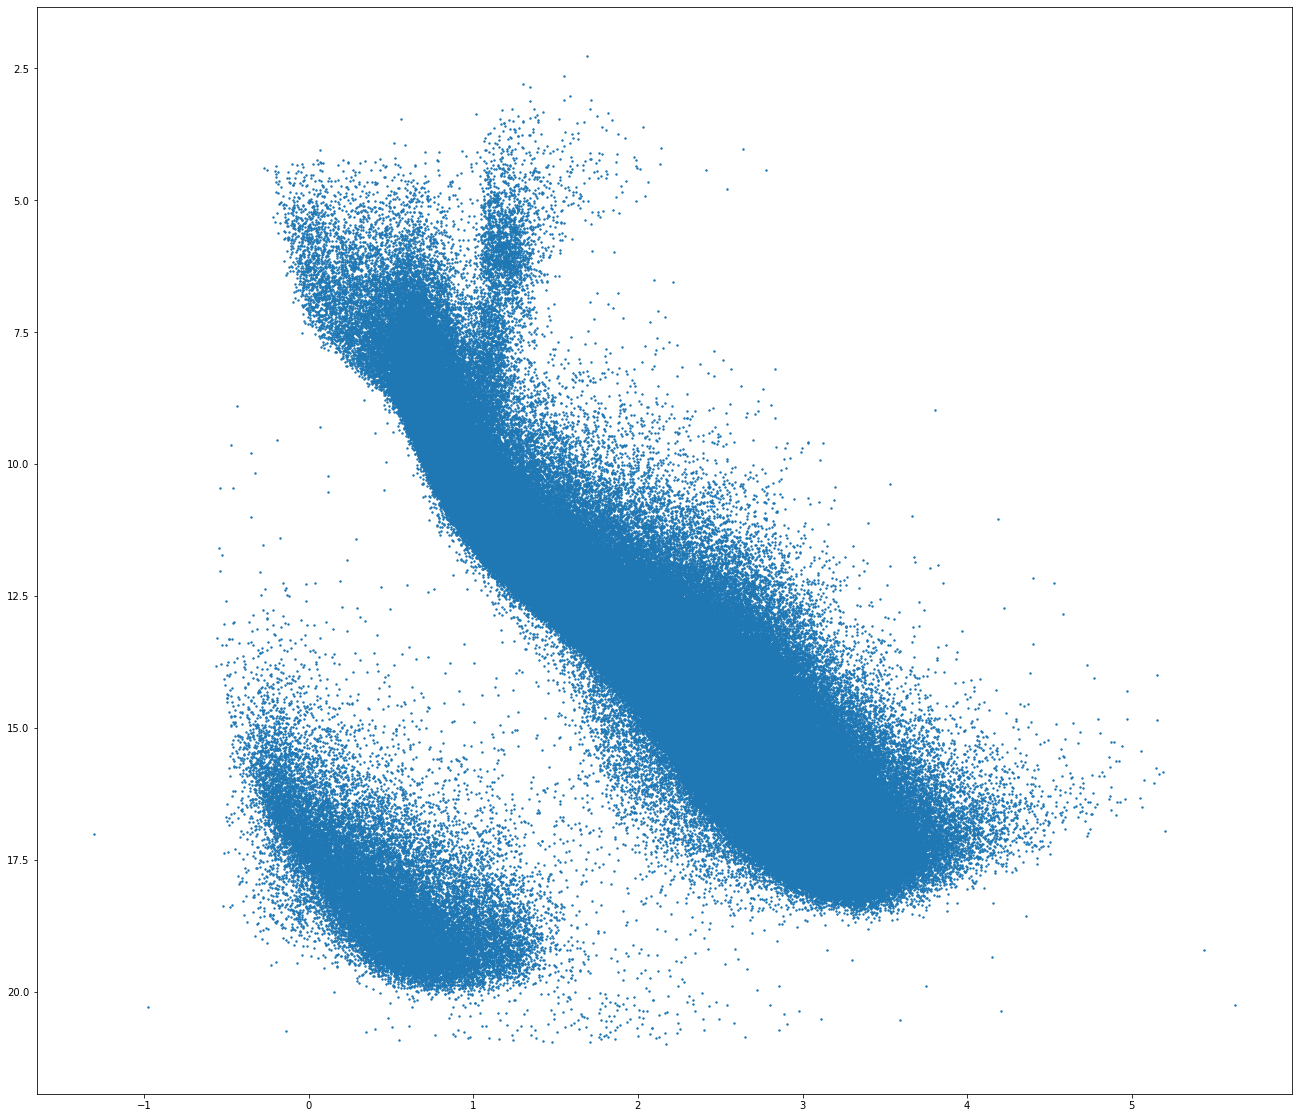

In [165]:
f, ax = plt.subplots(figsize=(22.5,20))
plt.scatter(x=stars_full_dataset['b-r(mag)'], y=stars_full_dataset['g_band(mag)'], s=2)
ax.invert_yaxis()

In [ ]:
comparation = pd.DataFrame()

comparation['all'] = stars_properties['freq'].value_counts()/len(stars_properties)
comparation['random'] = test_set['freq'].value_counts()/len(test_set)

comparation['random_error(%)'] = ((comparation['all']-comparation['random'])*100)/comparation['all']
comparation.info()